In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

# <span style="color:red">ch5_LSTM(RNN, GRN)</span>
- imdb사이트의 5만개 영화 감상평 : Train/test - 타겟변수:부정/긍정 

# 1. 패키지 import

In [93]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time # 유닉스time을 계산하기 위해

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense

from sklearn.metrics import confusion_matrix, recall_score, precision_score , f1_score
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# 2. 하이퍼파라미터 설정
- 하이퍼파라미터를 바꾸면 모델의 정확도나 속도에 차이남

In [105]:
MY_WORDS = 20000 # imdb 데이터 안의 단어 수
MY_LENGTH = 200 # 독립변수 차원(영화평 평균길이 정도) 
MY_EMBED = 32 # Embrdding 결과 차원
MY_HIDDEN = 64 # LSTM의 units 수

MY_EPOCH = 15 # fit 반복학습수
MY_BATCH = 200 # 배치사이즈(fit할 때, 매번 가져오는 데이터 수)

# 불용어 설정(빈도수가 높은 상위 1~30은 대부분 the, a, is...)
SKIP_TOP = 30

# 3. 데이터 불러오기

In [96]:
(X_train, y_train),(X_test, y_test) = imdb.load_data(num_words=MY_WORDS,# 1~MYWRODS이외는 2로 가져옴
                                                    skip_top=SKIP_TOP #1~20까지를 2로 가져옴
                                                    )

In [106]:
print('학습용 독립변수 모양 :', X_train.shape)
print('학습용 타겟변수 모양 :', y_train.shape)
print('학습용 독립변수 샘플 :', X_train[0][:80])
print('학습용 타켓변수(0:부정/1:긍정) 샘플 :', y_train[0])
print('테스트용 독립변수 모양 :', X_test.shape)
print('테스트용 타겟변수 모양 :', y_test.shape)

학습용 독립변수 모양 : (25000, 200)
학습용 타겟변수 모양 : (25000,)
학습용 독립변수 샘플 : [   2    2    2    2   43  530  973 1622 1385   65  458 4468   66 3941
    2  173   36  256    2    2  100   43  838  112   50  670    2    2
   35  480  284    2  150    2  172  112  167    2  336  385   39    2
  172 4536 1111    2  546   38    2  447    2  192   50    2    2  147
 2025    2    2    2    2 1920 4613  469    2    2   71   87    2    2
   43  530   38   76    2    2 1247    2    2    2]
학습용 타켓변수(0:부정/1:긍정) 샘플 : 1
테스트용 독립변수 모양 : (25000, 200)
테스트용 타겟변수 모양 : (25000,)


In [14]:
# 부/긍정 갯수
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

1    12500
0    12500
dtype: int64
0    12500
1    12500
dtype: int64


In [7]:
# 긍정 갯수
print('학습테이터의 긍정 갯수 :',y_train.sum())
print('테스트테이터의 긍정 갯수 :',y_test.sum())

학습테이터의 긍정 갯수 : 12500
테스트테이터의 긍정 갯수 : 12500


# 4. 문자단어 -> 정수

In [107]:
word_to_id = imdb.get_word_index() # 단어(word):정수(id) (빈도가 높은 단어는 앞)
print(word_to_id['movie'])
print(word_to_id.get('film'))
print(word_to_id['the'])
# 정수 -> 문자 단어
id_to_word = {} # 정수(id) : 문자단어
for key, value in word_to_id.items():
    id_to_word[value] = key
print(id_to_word[17])
print(id_to_word.get(19))
print(id_to_word.get(1))
# SKIP_TOP값을 고민하기 위해 최빈 단어(현재 SKIP_TOP값 20)

print([id_to_word[i] for i in range(1, 48)])

17
19
1
movie
film
the
['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'all', 'at', 'by', 'an', 'they', 'who', 'so', 'from', 'like', 'her', 'or', 'just', 'about', "it's", 'out', 'has', 'if', 'some', 'there']


In [99]:
msg = "What a wonderful movie"
msg = msg.lower().split()
print(msg)
# 1: 리뷰의 시작을 알리는 숫자, 2: MY_WORDS(10000)이내에 들어가지 않는 단어, 3:padding처리
data = [1] + [word_to_id.get(m, -1)+3 for m in msg]
print('원 후기 내용 :', msg)
print('encoded된 내용(data)_SKIP_TOP처리 안 할 경우 :', data)
data = [d if d>30 else 2 for d in data]
print('SKIP_TOP 처리 할 경우 :', data )
print('data 추정 :', )

['what', 'a', 'wonderful', 'movie']
원 후기 내용 : ['what', 'a', 'wonderful', 'movie']
encoded된 내용(data)_SKIP_TOP처리 안 할 경우 : [1, 51, 6, 389, 20]
SKIP_TOP 처리 할 경우 : [2, 51, 2, 389, 2]
data 추정 :


In [10]:
[id_to_word.get(d-3, '???') for d in data]

['???', 'what', 'a', 'wonderful', 'movie']

# 5. 숫자영화평->자연어 영화평 함수

In [23]:
def decoding(review_nums):
    decoded= [] # 숫자를 단어로 해석한 내용 append
    #print(review_nums)
    for num in review_nums:
        word = id_to_word.get(num - 3, '???')
        decoded.append(word)
    print(' '.join(decoded))

In [24]:
print(X_test[0])
print(decoding(X_train[0]))

[2, 591, 202, 2, 31, 2, 717, 2, 2, 2, 2, 2, 2, 360, 2, 2, 177, 2, 394, 354, 2, 123, 2, 2, 2, 2, 2, 2, 2, 92, 124, 89, 488, 2, 100, 28, 2, 2, 31, 23, 27, 2, 29, 220, 468, 2, 124, 2, 286, 170, 2, 157, 46, 2, 27, 239, 2, 179, 2, 38, 32, 25, 2, 451, 202, 2, 2, 717]
??? ??? film ??? just brilliant casting ??? ??? story direction ??? really ??? ??? part they played ??? you could just imagine being there robert ??? ??? an amazing actor ??? now ??? same being director ??? father came from ??? same ??? ??? ??? myself so ??? loved ??? fact there ??? ??? real ??? ??? ??? film ??? ??? ??? throughout ??? film were great ??? ??? just brilliant so much ??? ??? ??? ??? film ??? soon ??? ??? ??? released ??? ??? ??? would recommend ??? ??? everyone ??? watch ??? ??? ??? ??? ??? amazing really ??? at ??? end ??? ??? so sad ??? you know what they say if you ??? at ??? film ??? must have been good ??? ??? definitely ??? also ??? ??? ??? two little ??? ??? played ??? ??? ??? ??? ??? paul they were just bri

# 6. 영화평 학습용 데이터 처음10개의 길이 출력 함수

In [25]:
def show_length():
    print('첫 20개 영화평 길이')
#     for i in range(11):
#         print(f'{i}번째 길이 :{len(X_train[i])}')
    print([len(x) for x in X_train[:21]])
show_length()

첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [100]:
print('pad_sequence 작업전')
show_length()

pad_sequence 작업전
첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [15]:
max([len(x) for x in X_train]), min([len(x) for x in X_train])

(2494, 11)

In [28]:
# 영화평 길이 평균
np.array([len(x) for x in X_train]).mean()

238.71364

# 7. 모든 영화평의 길이를 동일하게(MY_LENGTH만큼)

In [101]:
X_train = pad_sequences(X_train,
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       #padding='post',
                       padding='pre' # 길 경우, 뒷부분을 짜르고 짧은 경우 뒤에 zero를 붙임
                     )
X_test = pad_sequences(X_test, 
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       #padding='post',
                       padding='pre' # 길 경우, 뒷부분을 짜르고 짧은 경우 뒤에 zero를 붙임
                     )
show_length()

첫 20개 영화평 길이
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


In [102]:
X_train[0]

array([   2,    2,    2,    2,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    2,  173,   36,  256,    2,    2,  100,   43,
        838,  112,   50,  670,    2,    2,   35,  480,  284,    2,  150,
          2,  172,  112,  167,    2,  336,  385,   39,    2,  172, 4536,
       1111,    2,  546,   38,    2,  447,    2,  192,   50,    2,    2,
        147, 2025,    2,    2,    2,    2, 1920, 4613,  469,    2,    2,
         71,   87,    2,    2,   43,  530,   38,   76,    2,    2, 1247,
          2,    2,    2,  515,    2,    2,    2,  626,    2,    2,    2,
         62,  386,    2,    2,  316,    2,  106,    2,    2, 2223, 5244,
          2,  480,   66, 3785,   33,    2,  130,    2,    2,   38,  619,
          2,    2,  124,   51,   36,  135,   48,    2, 1415,   33,    2,
          2,    2,  215,    2,   77,   52,    2,    2,  407,    2,   82,
          2,    2,    2,  107,  117, 5952,    2,  256,    2,    2,    2,
       3766,    2,  723,   36,   71,   43,  530,  4

# 8. 최종 데이터 shape 확인

In [108]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 200), (25000,), (25000, 200), (25000,))

In [109]:
decoding(X_train[0])

??? ??? ??? ??? just brilliant casting location scenery story direction everyone's really suited ??? part they played ??? ??? could just imagine being there robert ??? ??? an amazing actor ??? now ??? same being director ??? father came from ??? same scottish island ??? myself so ??? loved ??? fact there ??? ??? real connection ??? ??? ??? ??? witty remarks throughout ??? ??? were great ??? ??? just brilliant so much ??? ??? bought ??? ??? ??? soon ??? ??? ??? released ??? ??? ??? would recommend ??? ??? everyone ??? watch ??? ??? fly fishing ??? amazing really cried at ??? end ??? ??? so sad ??? ??? know what they say if ??? cry at ??? ??? ??? must ??? been good ??? ??? definitely ??? also ??? ??? ??? two little boy's ??? played ??? ??? ??? norman ??? paul they were just brilliant children ??? often left out ??? ??? ??? list ??? think because ??? stars ??? play them all grown up ??? such ??? big profile ??? ??? whole ??? ??? these children ??? amazing ??? should be praised ??? what th

# 9. 모델 생성 및 구현

In [110]:
model = Sequential() 
model.add(Embedding(input_dim=MY_WORDS, # 10000
                   output_dim=MY_EMBED, # 32
                   input_length=MY_LENGTH))
model.add(LSTM(units=MY_HIDDEN,
               dropout=0.5, # 0.1~0.5 각 스텝마다 LSTM셀로 들어가는 연결 30% 0으로
             #  recurrent_dropout=0.2 # 0.1~0.3 이전 LSTM에서 다음 LSTM셀로 가는 연결 20% 0으로
             # input_shape=(MY_LENGTH,MY_HIDDEN),
             # kernel_initializer='he_normal', # 입력 가중치 초기화
             # recurrent_initializer='orthogonal' # 순환 가중치 초기화
              ))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 32)           640000    
                                                                 
 lstm_2 (LSTM)               (None, 64)                24832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 664,897
Trainable params: 664,897
Non-trainable params: 0
_________________________________________________________________


# 10. 학습환경 설정 및 학습하기

In [111]:
model.compile(loss='binary_crossentropy', # 이중분류(로지스틱회귀분석)
              optimizer='adam',
              metrics=['acc']
             )
start = time() # 70.1.1 ~ 이 시점까지 초수
hist = model.fit(X_train, y_train,
                epochs=MY_EPOCH,
                batch_size=MY_BATCH,
                validation_split=0.2,
                verbose=1)
end = time() # 70.1.1 ~ 이 시점까지 초수
print('총 fit 시간 : {:.5f}'.format(end-start))


Epoch 1/15
100/100 [==============================] - 43s 405ms/step - loss: 0.5946 - acc: 0.6672 - val_loss: 0.3751 - val_acc: 0.8532
Epoch 2/15
100/100 [==============================] - 35s 351ms/step - loss: 0.3280 - acc: 0.8684 - val_loss: 0.3100 - val_acc: 0.8720
Epoch 3/15
100/100 [==============================] - 40s 400ms/step - loss: 0.2447 - acc: 0.9066 - val_loss: 0.3106 - val_acc: 0.8798
Epoch 4/15
100/100 [==============================] - 38s 378ms/step - loss: 0.2034 - acc: 0.9241 - val_loss: 0.3136 - val_acc: 0.8796
Epoch 5/15
100/100 [==============================] - 35s 346ms/step - loss: 0.1828 - acc: 0.9337 - val_loss: 0.3295 - val_acc: 0.8764
Epoch 6/15
100/100 [==============================] - 35s 348ms/step - loss: 0.1724 - acc: 0.9380 - val_loss: 0.3448 - val_acc: 0.8690
Epoch 7/15
100/100 [==============================] - 39s 386ms/step - loss: 0.1393 - acc: 0.9505 - val_loss: 0.3550 - val_acc: 0.8662
Epoch 8/15
100/100 [==============================] - 3

# 11.모델평가

In [35]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

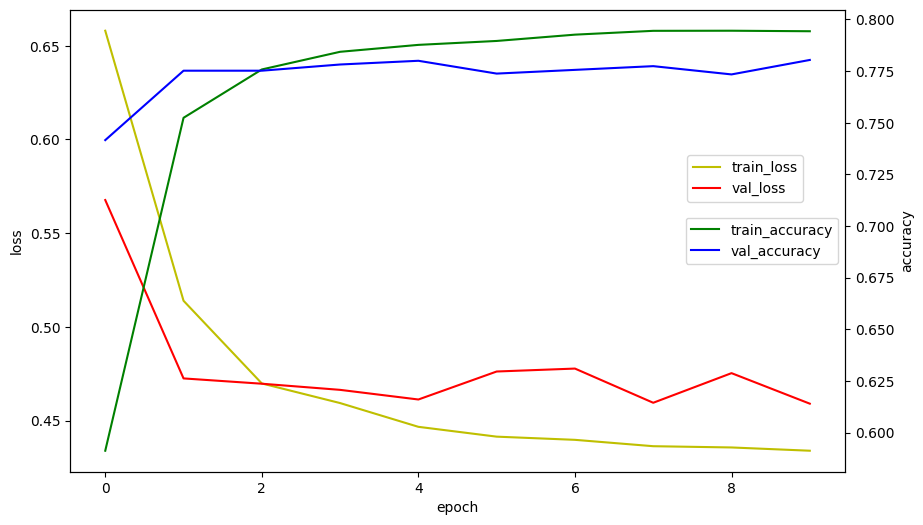

In [39]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['acc'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [40]:
# 테스트 데이터로 평가
loss, acc = model.evaluate(X_test, y_test)
print('test의 데이터 정확도 :', acc)

782/782 [==============================] - 8s 10ms/step - loss: 0.4570 - acc: 0.7781
test의 데이터 정확도 : 0.7780799865722656


In [43]:
# 모델 저장
model.save('imdb_v2.10_skip20legth80.h5')

In [49]:
# 혼동행렬(교차표, 평가성능지표)
# y_test 실제값
pred = model.predict(X_test)
y_hat = (pred>0.5).astype(int) # 예측값
# y_hat

782/782 [==============================] - 8s 11ms/step


array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [50]:
y_test.shape, y_hat.shape

((25000,), (25000, 1))

In [51]:
# 실제값(1차원)과 예측값(2차원)의 차원이 같지 않아도 됨
confusion_matrix(y_test, y_hat)

array([[9516, 2984],
       [2564, 9936]], dtype=int64)

In [59]:
# 실제값과 예측값의 차원이 1차원
ctab = pd.crosstab(y_test, y_hat.reshape(-1), rownames=['실제값'], colnames=['예측값'])
ctab['0확률'] = [ctab.loc[0,0]/25000*100, ctab.loc[1,0]/25000*100]
ctab['1확률'] = [ctab.loc[0,1]/25000*100, ctab.loc[1,1]/25000*100]
ctab          

예측값,0,1,0확률,1확률
실제값,,,,
0,9516,2984,38.064,11.936
1,2564,9936,10.256,39.744


In [64]:
# accuracy, precision, recall, f1_score
print('acc :', acc)
print('precision : ',precision_score(y_test, y_hat))
print('recall : ', recall_score(y_test, y_hat))
print('f1 score : ',f1_score(y_test, y_hat))

acc : 0.7780799865722656
precision :  0.7690402476780186
recall :  0.79488
f1 score :  0.7817466561762392


# 12. 모델 사용하기

In [81]:
import re
review ="""This film is a beautifully crafted piece of work. The narrative is compelling from start to finish, and the characters feel incredibly real. The cinematography and soundtrack blend perfectly, creating an atmosphere that stays with you long after the movie ends. Highly recommended. ^_^ :)""".lower()
review = re.sub('[^a-zA-Z0-9\s]', ' ',review)
review = review.split()
print(review)
encoded = [1] + [word_to_id.get(r, -1 )+3 for r in review]
encoded = [2 if (e<=30) | (e>10000) else e for e in encoded] # skip_top 사용시
print(encoded, len(encoded))

['this', 'film', 'is', 'a', 'beautifully', 'crafted', 'piece', 'of', 'work', 'the', 'narrative', 'is', 'compelling', 'from', 'start', 'to', 'finish', 'and', 'the', 'characters', 'feel', 'incredibly', 'real', 'the', 'cinematography', 'and', 'soundtrack', 'blend', 'perfectly', 'creating', 'an', 'atmosphere', 'that', 'stays', 'with', 'you', 'long', 'after', 'the', 'movie', 'ends', 'highly', 'recommended']
[2, 2, 22, 2, 2, 2, 2, 418, 2, 157, 2, 2, 2, 2, 39, 380, 2, 2, 2, 2, 105, 235, 966, 147, 2, 627, 2, 816, 2, 950, 2, 35, 841, 2, 2, 2, 25, 196, 103, 2, 2, 630, 545, 2] 44


In [83]:
input_data = pad_sequences([encoded],
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       #padding='post',
                       padding='pre' # 길 경우, 뒷부분을 짜르고 짧은 경우 뒤에 zero를 붙임
                     )
input_data

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   2,  22,
          2,   2,   2,   2, 418,   2, 157,   2,   2,   2,   2,  39, 380,
          2,   2,   2,   2, 105, 235, 966, 147,   2, 627,   2, 816,   2,
        950,   2,  35, 841,   2,   2,   2,  25, 196, 103,   2,   2, 630,
        545,   2]])

In [86]:
(model.predict(input_data) > 0.5 ).astype('int8')

1/1 [==============================] - 0s 31ms/step


array([[1]], dtype=int8)

In [90]:
review ="""This is one of the worst films I have ever seen. The story is painfully predictable and drags without any meaningful direction. ^.^The characters feel lifeless, and their motivations never make sense. The dialogue is awkward, making every scene even harder to watch. The cinematography looks cheap, as if no effort was put into creating a coherent visual style. Even the soundtrack feels random and distracting. By the time it ends, the film leaves nothing but frustration and the sense that your time has been completely wasted. It is a truly unbearable experience from beginning to end for any viewer."""
review = re.sub('[^a-zA-Z0-9\s]', ' ', review)
review = review.lower().split()
encoded = [1] + [word_to_id.get(r, -1)+3 for r in review]
encoded = [e if(e>=30) & (e<=10000) else 2 for e in encoded]
print(encoded, len(encoded))

[2, 2, 2, 31, 2, 2, 249, 108, 2, 28, 126, 110, 2, 65, 2, 2, 727, 2, 2, 209, 101, 2, 458, 2, 105, 235, 2, 2, 68, 2, 115, 97, 281, 2, 414, 2, 2, 231, 175, 136, 60, 2, 2, 106, 2, 627, 272, 706, 2, 48, 57, 781, 2, 276, 83, 2, 2, 2, 2, 405, 60, 2, 816, 764, 2, 2, 2, 34, 2, 58, 2, 630, 2, 22, 889, 164, 21, 2, 2, 2, 281, 2, 129, 58, 47, 77, 340, 2, 2, 2, 2, 371, 2, 585, 39, 454, 2, 130, 2, 101, 529] 101


In [92]:
input_data = pad_sequences([encoded],
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       #padding='post',
                       padding='pre' # 길 경우, 뒷부분을 짜르고 짧은 경우 뒤에 zero를 붙임
                     )
(model.predict(input_data) > 0.5 ).astype('int8')

1/1 [==============================] - 0s 26ms/step


array([[0]], dtype=int8)